In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings, pickle, os
warnings.filterwarnings("ignore")

In [2]:
data = pickle.load(open('data/inverse/cust_id.pkl', 'rb'))

In [3]:
date = None
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        count = 0 # 每小時交易次數
        max_count = 0 # 樣本中最大的每小時交易次數
        sum_count = 0
        hour = 0
        for v3 in v2["data"]:
            if v3["source"] == 2:
                if date != v3["date"]:
                    date = v3["date"]
                    count = 1
                    hour += 1
                else:
                    count += 1

                sum_count += 1
                max_count = max(max_count, count)
        
        
        freq = sum_count/hour if hour != 0 else 0
        v2["data"][-1]["dp_freq"] = freq
        v2["data"][-1]["dp_count"] = max_count

In [4]:
# 所有sample加上sar，並分開各來源的資料
info = []
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        for v3 in v2["data"]:
            if v3["source"] == 4:
                info.extend([v3])
df = pd.DataFrame(info)

In [5]:
df['month'] = df["date"].dt.month
df['day'] = df["date"].dt.day

df['month_sin'] = np.sin(2 * np.pi *  df['month']/ df["month"].max())
df['month_cos'] = np.cos(2 * np.pi * df['month'] / df["month"].max())

df['day_sin'] = np.sin(2 * np.pi * df['day'] / df["day"].max())
df['day_cos'] = np.cos(2 * np.pi * df['day'] / df["day"].max())

df = df.drop(["month", "day", "date", "source"], axis = 1)

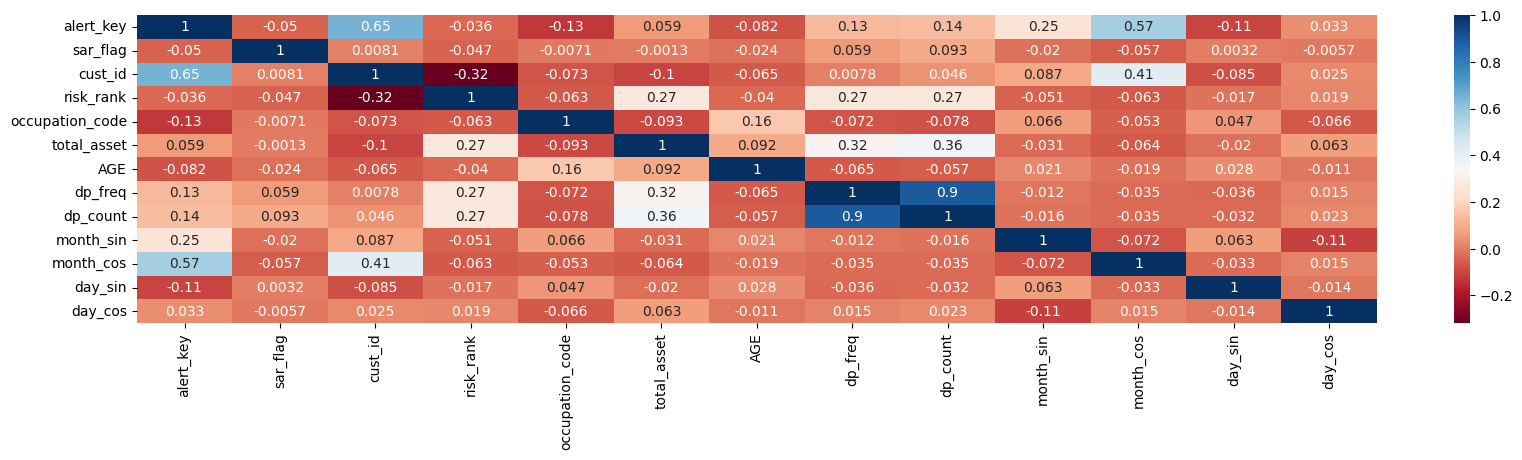

In [6]:
plt.figure(figsize=(20, 4))
corr = df.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

In [7]:
target = "sar_flag"
train = df[~df[target].isnull()].reset_index(drop = True)
test = df[df[target].isnull()].reset_index(drop = True)

In [8]:
train = train.dropna().reset_index(drop = True)

# Split train、valid data

In [9]:
drop_feat = ["alert_key", "sar_flag"]

In [10]:
X_train = train.drop(drop_feat, axis = 1)
y_train = train["sar_flag"]

X_test = test.drop(drop_feat, axis = 1)

In [11]:
print(f"raw 1/0: {(y_train.value_counts()[1] / y_train.value_counts()[0]):.4}")
y_train.value_counts()

raw 1/0: 0.009934


0.0    23556
1.0      234
Name: sar_flag, dtype: int64

In [12]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state = 99)
# X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.3, shuffle = False)
print(X_train1.shape, X_valid.shape, y_train1.shape, y_valid.shape)

(19032, 11) (4758, 11) (19032,) (4758,)


In [13]:
print(f"train 1/0: {(y_train1.value_counts()[1] / y_train1.value_counts()[0]):.4}")
y_train1.value_counts()

train 1/0: 0.009923


0.0    18845
1.0      187
Name: sar_flag, dtype: int64

In [14]:
print(f"valid 1/0: {(y_valid.value_counts()[1] / y_valid.value_counts()[0]):.4}")
y_valid.value_counts()

valid 1/0: 0.009977


0.0    4711
1.0      47
Name: sar_flag, dtype: int64

## Resample

In [15]:
from imblearn.over_sampling import SMOTE, ADASYN
oversample = SMOTE(random_state=99)
X_train1, y_train1 = oversample.fit_resample(X_train1, y_train1)
y_train1.value_counts()

0.0    18845
1.0    18845
Name: sar_flag, dtype: int64

In [16]:
oversample = SMOTE(random_state=99)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0.0    23556
1.0    23556
Name: sar_flag, dtype: int64

## Target encoding

In [17]:
X_train1.head(3)

,cust_id,risk_rank,occupation_code,total_asset,AGE,dp_freq,dp_count,month_sin,month_cos,day_sin,day_cos
0,6567,1,9.0,253475.0,3,0.000000,0,8.660254e-01,5.000000e-01,-0.101168,-0.994869
1,7218,1,19.0,1075983.0,3,4.000000,4,1.000000e+00,6.123234e-17,-0.201299,0.979530
2,5460,1,18.0,0.0,2,1.166667,3,-2.449294e-16,1.000000e+00,0.571268,0.820763


In [18]:
cat_col = ['cust_id', 'risk_rank', 'occupation_code', 'AGE']
train[cat_col] = train[cat_col].astype(int)

In [19]:
import category_encoders as ce

cat_feat = ['cust_id', 'risk_rank', 'occupation_code', 'AGE']
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train1 = ce_target.fit_transform(X_train1, y_train1)
X_valid = ce_target.transform(X_valid)

In [20]:
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

## Modeling

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    # "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state),#, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train1, y_train1)
    print(name + " trained.")

Logistic trained.
Bayes (Gaussian) trained.
KNN trained.
Decision Tree trained.
Random Forest trained.
Gradient Boost trained.
XGBoost trained.
LightGBM trained.
Easy Ensemble (AdaBoost) trained.
Easy Ensemble (Logistic) trained.


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

# acc_bound = 0.7
# f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_valid)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_valid, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_valid, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_valid, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_valid, pred_test).round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    # if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
    col3 = sorted(list(set(y_valid) | set(pred_test)))
    confusion = pd.DataFrame(confusion_matrix(y_valid, pred_test), index = col3, columns = col3)
    confusion["Total"] = confusion.sum(axis = 1)
    confusion.loc["Total"] = confusion.sum(axis = 0)

    
    confusion = confusion.astype(int)
    
    print(f"<< {key.lstrip()} >>")
    print(f"\nConfusion Matrix:\n {confusion}")
    print(f"\nClassification Report:\n{classification_report(y_valid, pred_test)}")
    print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score = score.sort_values(["Recall_test", "Precision_test", "f1_test", "Accuracy_test"], ascending = False)
score

<< Logistic >>

Confusion Matrix:
         0.0  1.0  Total
0.0    4207  504   4711
1.0      44    3     47
Total  4251  507   4758

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      4711
         1.0       0.01      0.06      0.01        47

    accuracy                           0.88      4758
   macro avg       0.50      0.48      0.47      4758
weighted avg       0.98      0.88      0.93      4758

------------------------------------------------------------
<< Bayes (Gaussian) >>

Confusion Matrix:
        0.0   1.0  Total
0.0    269  4442   4711
1.0      3    44     47
Total  272  4486   4758

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.06      0.11      4711
         1.0       0.01      0.94      0.02        47

    accuracy                           0.07      4758
   macro avg       0.50      0.50      0.06      4758
weighted avg       0.9

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test
Bayes (Gaussian),0.50,0.07,0.94,0.94,0.50,0.01,0.65,0.02
LightGBM,0.99,0.92,0.99,0.60,0.99,0.07,0.99,0.13
XGBoost,0.99,0.92,0.99,0.57,0.99,0.07,0.99,0.12
Random Forest,0.99,0.93,0.98,0.53,0.99,0.08,0.99,0.13
KNN,0.82,0.83,0.76,0.53,0.86,0.03,0.81,0.06
Gradient Boost,0.99,0.95,0.98,0.51,0.99,0.10,0.99,0.16
Decision Tree,0.97,0.92,0.97,0.51,0.97,0.07,0.97,0.12
Easy Ensemble (AdaBoost),0.98,0.92,0.98,0.51,0.99,0.07,0.98,0.12
Logistic,0.47,0.88,0.04,0.06,0.26,0.01,0.07,0.01
Easy Ensemble (Logistic),0.47,0.88,0.04,0.06,0.26,0.01,0.07,0.01


In [23]:
best_model = score.index[0]
best_model

'Bayes (Gaussian)'

## Recall@N - 1 的 Precision

In [24]:
pred_valid  = models[best_model].predict_proba(X_valid)
pred_valid = pred_valid[:, 1]

valid = train.loc[y_valid.index]
valid = valid[["alert_key", "sar_flag"]]
valid["probability"] = pred_valid
valid = valid.sort_values("probability", ascending = False)
sar = np.where(valid["sar_flag"])[0]
recall = len(sar)/sar[-2]
print(f"total: {len(valid)},  SAR: {len(sar)}\n{len(sar)} / {sar[-1]} = {recall:.6}")

total: 4758,  SAR: 47
47 / 4711 = 0.0101754


## Submit

#### No valid: only use X_train to train

In [25]:
test_model = models[best_model]
# test_model.fit(X_train1, y_train1)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1744


array([0.59336659, 0.59309532, 0.59309495, ..., 0.58519442, 0.58718921,
       0.58814671])

#### Total train: use X_train and X_valid to train

In [26]:
test_model = models[best_model]
test_model.fit(X_train, y_train)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1751


array([0.60339384, 0.60315699, 0.60315748, ..., 0.59548243, 0.59584767,
       0.59668246])

In [27]:
result = test[["alert_key"]].copy()
result["probability"] = pred_prob
result

,alert_key,probability
0,357658,0.603394
1,354015,0.603157
2,358197,0.603157
3,360812,0.603155
4,361685,0.602908
...,...,...
1840,364964,0.603389
1841,364976,0.599623
1842,364977,0.595482
1843,364978,0.595848


In [38]:
root = os.getcwd()
submit = pd.read_csv(root + "\\data\\submit\\預測的案件名單及提交檔案範例.csv")
submit = submit[["alert_key"]]
submit = pd.merge(submit, result, on = "alert_key", how = "left")
submit["probability"] = submit["probability"].astype(float)
submit = submit.fillna(1e-20)
submit = submit.sort_values("probability", ascending = False)
submit

,alert_key,probability
3735,363038,6.186980e-01
2369,356399,6.146545e-01
2680,354778,6.136624e-01
1774,353823,6.125616e-01
3365,356911,6.114812e-01
...,...,...
1648,371071,1.000000e-20
1650,369630,1.000000e-20
1651,373443,1.000000e-20
1652,374325,1.000000e-20


In [39]:
submit.to_csv("data/submit/1116.csv", index = False)